<a href="https://colab.research.google.com/github/julie-dfx/causal-decision-analytics/blob/main/00_reboot_07_hypothesis_testing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Hypothesis testing from first principles

## Business question
Does issuing compensation improve 28-day retention, or could the observed difference be explained by random variation alone?

## Statistical question
How surprising would the observed data be if compensation had no effect?

## Define null world: Null Hypothesis (H0)

Issuing compensation has no effect on retention. Any observed difference is due to random variation.

The null is a data-generating world, not an opinion

In [1]:
# Simulate null world
import numpy as np

#Assume retention is the same regardless of compensation
n = 1000
true_retention_rate = 0.60

#simulate 2 groups under the null
ret_comp = np.random.binomial(1, true_retention_rate, n)
ret_no_comp = np.random.binomial(1, true_retention_rate, n)

observed_diff = ret_comp.mean() - ret_no_comp.mean()
observed_diff

# this is a fake universe where the null hypothesis is true

np.float64(-0.018000000000000016)

In [2]:
#repeat the null world many times

diffs = []

for _ in range(5000):
  ret_comp = np.random.binomial(1, true_retention_rate, n)
  ret_no_comp = np.random.binomial(1, true_retention_rate, n)
  diffs.append(ret_comp.mean() - ret_no_comp.mean())

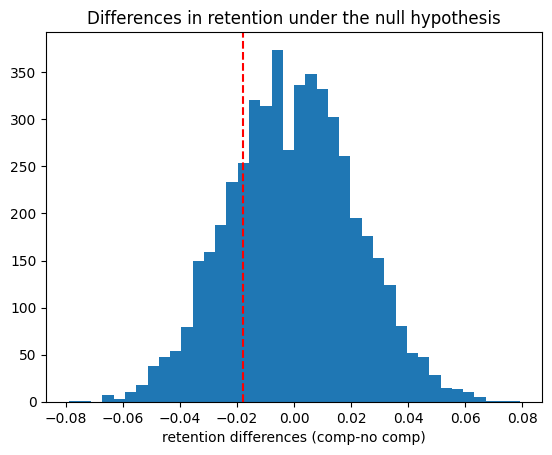

In [3]:
import matplotlib.pyplot as plt
plt.figure()
plt.hist(diffs, bins=40)
plt.axvline(observed_diff, color='red', linestyle='--')
plt.title('Differences in retention under the null hypothesis')
plt.xlabel("retention differences (comp-no comp)")
plt.show()

#most differences cluster around zero
#some differences are larger just by chance
#the question is: is what we observed rare in this null world?

## Mental model:

A hypothesis test asks:
"If the null hypothesis were true, how unsure would this data be?"
It does not ask "Is the null hypothesis true"

## Null and alternative worlds

HO: Compensation has no effect on retention
H1: Compensation improves retention

In [4]:
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(22)
n = 1000
baseline = 0.60
effect = 0.03 #3pp improvement under H1

#null worlds
diffs_null = []
#alternative world
diffs_alt = []

for _ in range(5000):
  #HO
  ret_comp = np.random.binomial(1, baseline, n)
  ret_no_comp = np.random.binomial(1, baseline, n)
  diffs_null.append(ret_comp.mean() - ret_no_comp.mean())

  #H1
  ret_comp = np.random.binomial(1, baseline + effect, n)
  ret_no_comp = np.random.binomial(1, baseline, n)
  diffs_alt.append(ret_comp.mean() - ret_no_comp.mean())

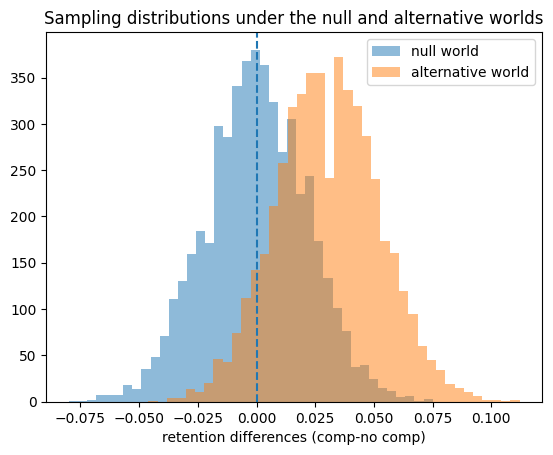

In [5]:
plt.figure()
plt.hist(diffs_null, bins=40, alpha=0.5, label='null world')
plt.hist(diffs_alt, bins=40, alpha=0.5, label='alternative world')
plt.axvline(0.0, linestyle="--")
plt.legend()
plt.title('Sampling distributions under the null and alternative worlds')
plt.xlabel("retention differences (comp-no comp)")
plt.show()

In [6]:
#intrduce a decision threshold
threshold = 0.015

#compute errors
type1 = np.mean(np.array(diffs_null) > threshold) #rejecting H0 when H0 is true ie believing comp works when it doesnt (wasted money)
type2 = np.mean(np.array(diffs_alt) <= threshold) #failing to reject H0 when H1 is true ie believing comp doenst work when it actually does (lost opportunity)

print(f"Type 1 error: {type1}, Type 2 error: {type2}")

Type 1 error: 0.2504, Type 2 error: 0.2336


## Interpretation

Choosing a significance threshold is a risk management decision.
Lower thresholds reduce false positives but increase false negatives.
The appropriate balance depends on the relative costs of these errors

In [7]:
observed = 0.022 #pretend this is what we observed in real data (real world)

p_value = np.mean(np.array(diffs_null) >= observed) #faction of null-world outcomes as/more extreme than observed
p_value

np.float64(0.161)

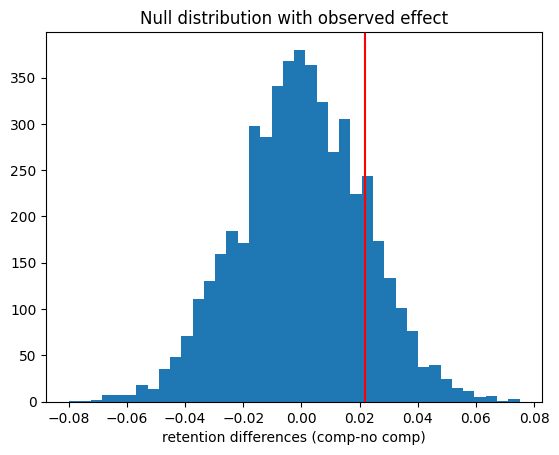

In [8]:
#visuallise it

plt.figure()
plt.hist(diffs_null, bins=40)
plt.axvline(observed, color='red')
plt.title("Null distribution with observed effect")
plt.xlabel("retention differences (comp-no comp)")
plt.show()


#red line = what happened (observed)
#histogram = what usually happens if null is true
#p-value = area to the right of the red line

## Definition of a p-value

The p-value is the probability of observing a result at least as extreme as the one obtained, assuming the null hypothesis is true

## Mental Model

A p-value measures how incompatible the observed data is with the null world.
It does not measure how true or false the null hypothesis is